## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import missingno as msno

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings('ignore')

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

**Загрузка данных**

In [4]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
train_data.shape

(7500, 17)

In [6]:
train_data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [7]:
test_data = pd.read_csv(TEST_DATASET_PATH)
test_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
test_data.shape

(2500, 16)

In [9]:
df = pd.concat([train_data, test_data], axis=0)

#### Подготовка данных

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 2499
Data columns (total 17 columns):
Annual Income                   7930 non-null float64
Bankruptcies                    9983 non-null float64
Credit Default                  7500 non-null float64
Credit Score                    7930 non-null float64
Current Credit Balance          10000 non-null float64
Current Loan Amount             10000 non-null float64
Home Ownership                  10000 non-null object
Maximum Open Credit             10000 non-null float64
Monthly Debt                    10000 non-null float64
Months since last delinquent    4561 non-null float64
Number of Credit Problems       10000 non-null float64
Number of Open Accounts         10000 non-null float64
Purpose                         10000 non-null object
Tax Liens                       10000 non-null float64
Term                            10000 non-null object
Years in current job            9543 non-null object
Years of Credit Histor

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,7930.0,1.366525e+06,8.638276e+05,106533.0,845989.25,1168813.5,1638693.00,1.497561e+07
Bankruptcies,9983.0,1.145948e-01,3.497292e-01,0.0,0.00,0.0,0.00,5.000000e+00
Credit Default,7500.0,2.817333e-01,4.498740e-01,0.0,0.00,0.0,1.00,1.000000e+00
Credit Score,7930.0,1.171992e+03,1.639813e+03,585.0,711.00,731.0,743.00,7.510000e+03
Current Credit Balance,10000.0,2.914741e+05,3.339979e+05,0.0,113225.75,209019.0,361950.00,6.506797e+06
Current Loan Amount,10000.0,1.194381e+07,3.200878e+07,11242.0,180548.50,311718.0,521070.00,1.000000e+08
Maximum Open Credit,10000.0,8.865079e+05,1.389982e+07,0.0,278811.50,478181.0,794359.50,1.304726e+09
Monthly Debt,10000.0,1.830368e+04,1.183165e+04,0.0,10059.75,16200.0,23888.25,1.366790e+05
Months since last delinquent,4561.0,3.456457e+01,2.177199e+01,0.0,16.00,32.0,50.00,1.180000e+02
Number of Credit Problems,10000.0,1.680000e-01,5.145896e-01,0.0,0.00,0.0,0.00,1.500000e+01


In [12]:
numerical_features = train_data.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 13


Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')

In [13]:
df['credit_scoreNAN'] = np.where(df['Credit Score'].isnull(), 1, 0)

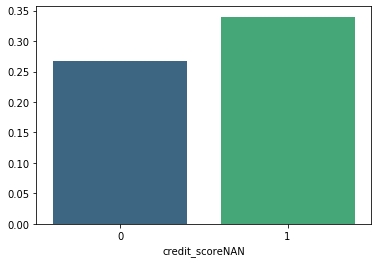

In [14]:
statistics = df.groupby(['credit_scoreNAN'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

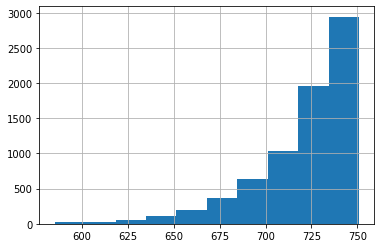

In [15]:
df[df['Credit Score'] < 2000]['Credit Score'].hist()

In [16]:
df['credit_score'] = df['Credit Score'].apply(lambda x: min(x, 2000))

In [17]:
df['credit_score'] = np.where(df['credit_score'].isnull(), -1000, df['credit_score'])

Сгруппируем credit_score по диапазонам в 10 значений, чтобы посмотреть распределение целевой переменной для разных значений credit_score на гистограмме

In [18]:
df['credit_score10'] = df['credit_score'].apply(lambda x: round(x/10))

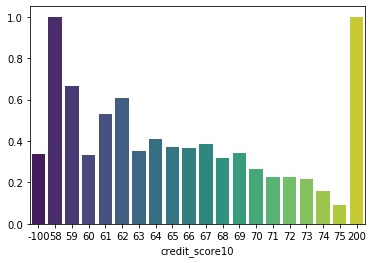

In [19]:
statistics = df.groupby(['credit_score10'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [20]:
df.groupby(['Home Ownership'], as_index=False).agg({'Credit Default':['count', 'mean']})

Home Ownership Credit Default          
                          count      mean
0  Have Mortgage             12  0.166667
1  Home Mortgage           3637  0.251856
2       Own Home            647  0.296754
3           Rent           3204  0.313046

In [21]:
df['is_train'] = np.where(df['Credit Default'].isnull(), 1, 0)

In [22]:
df.groupby(['Home Ownership'], as_index=False).agg({'is_train':['count', 'mean']})

Home Ownership is_train          
                    count      mean
0  Have Mortgage       19  0.368421
1  Home Mortgage     4862  0.251954
2       Own Home      895  0.277095
3           Rent     4224  0.241477

In [23]:
df['Home Ownership'].value_counts()

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

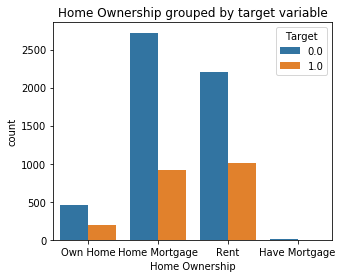

In [24]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [25]:
df2 = df.groupby(['Home Ownership'], as_index=False).agg({'Credit Default':'mean'})
df2.rename(columns={'Credit Default': 'home_ownership_mean'} , inplace=True)
df2

,Home Ownership,home_ownership_mean
0,Have Mortgage,0.166667
1,Home Mortgage,0.251856
2,Own Home,0.296754
3,Rent,0.313046


In [26]:
df = df.merge(df2, on='Home Ownership', how='left')

Количество строк с "Home Ownership" = "Have Mortgage" незначительно. Объединим их с "Home Mortgage" (возможно это изначально одно и то же)

is_train техническая переменная для удобства разделения трейна и теста

In [27]:
df.groupby('is_train', as_index=False).agg({'Annual Income':['count', 'mean', 'median']})

is_train Annual Income                         
                   count          mean     median
0        0          5943  1.366392e+06  1168386.0
1        1          1987  1.366922e+06  1178475.0

In [28]:
df.groupby('Credit Default', as_index=False).agg({'Annual Income':['count', 'mean', 'median']})

Credit Default Annual Income                         
                         count          mean     median
0            0.0          4359  1.418047e+06  1225747.0
1            1.0          1584  1.224243e+06  1055915.5

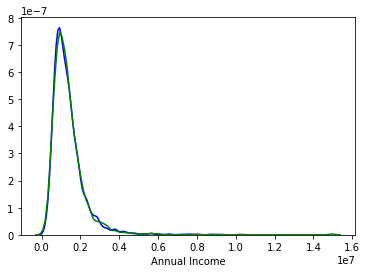

In [29]:
sns.distplot(train_data.loc[np.isnan(train_data['Annual Income'])==False, 'Annual Income'], hist = False, kde = True, color="b")
sns.distplot(test_data.loc[np.isnan(test_data['Annual Income'])==False, 'Annual Income'], hist = False, kde = True, color="g")


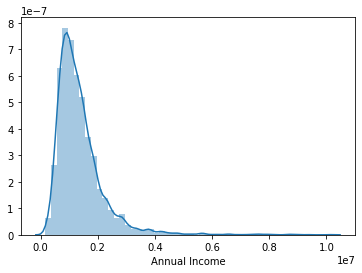

In [30]:
sns.distplot(train_data.loc[np.isnan(train_data['Annual Income'])==False, 'Annual Income'])

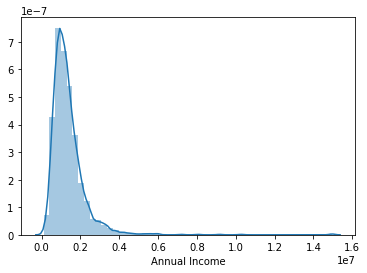

In [31]:
sns.distplot(test_data.loc[np.isnan(test_data['Annual Income'])==False, 'Annual Income'])

Визуально распределение 'Annual Income' на трейне и тесте очень похоже, что хорошо для модели

In [32]:
df['Annual Income'].quantile(.995)/1e7

0.5668941839999977

In [33]:
df['annual_incom_redict'] = df['Annual Income']

In [34]:
df['annual_incom_redict'].median()/1e7

0.11688135

In [35]:
df.loc[df['annual_incom_redict'] > df['annual_incom_redict'].quantile(.995), 'annual_incom_redict'] = df['Annual Income'].quantile(.995)

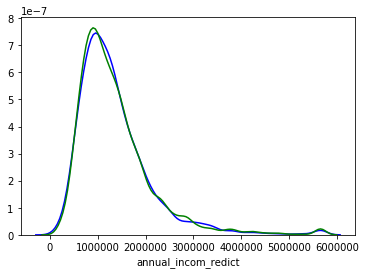

In [36]:
sns.distplot(df.loc[(np.isnan(df['annual_incom_redict'])==False) & (df['is_train']==1), 'annual_incom_redict'], hist = False, kde = True, color="b")
sns.distplot(df.loc[(np.isnan(df['annual_incom_redict'])==False) & (df['is_train']==0), 'annual_incom_redict'], hist = False, kde = True, color="g")


In [37]:
data = df.copy()
data.annual_incom_redict = np.where(data.annual_incom_redict.isnull(), 1, 0)
statistics = data.groupby('annual_incom_redict')['Credit Default'].mean()

In [38]:
statistics

annual_incom_redict
0    0.266532
1    0.339756
Name: Credit Default, dtype: float64

<BarContainer object of 2 artists>

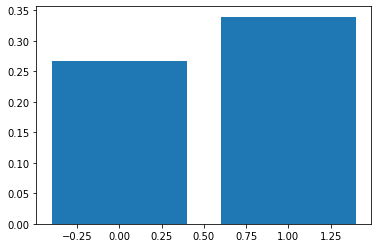

In [39]:
plt.bar(statistics.index, statistics.values)

In [40]:
df.loc[df.annual_incom_redict < 0, 'annual_incom_redict']

Series([], Name: annual_incom_redict, dtype: float64)

Заполним пропусти значением, которое заведомо отсутствовало

In [41]:
df.loc[df.annual_incom_redict.isnull(), 'annual_incom_redict'] = -10000

Пустые/непустые значения выделим в отдельный признак

In [42]:
df['annual_incom_NAN'] = np.where(df.annual_incom_redict < 0, 1, 0)

In [43]:
df.annual_incom_redict.describe()

count    1.000000e+04
mean     1.073420e+06
std      8.910746e+05
min     -1.000000e+04
25%      5.321425e+05
50%      9.910305e+05
75%      1.498297e+06
max      5.668942e+06
Name: annual_incom_redict, dtype: float64

In [44]:
df['annual_incom_redict500'] = df.annual_incom_redict.apply(lambda x: min(round(x/500000),5))

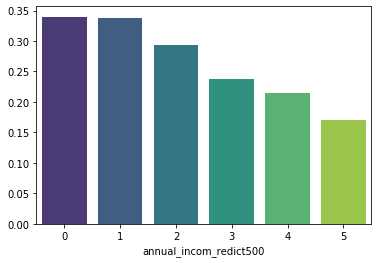

In [45]:
statistics = df.groupby(['annual_incom_redict500'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [46]:
df.groupby('annual_incom_NAN')['Credit Default'].mean()

annual_incom_NAN
0    0.266532
1    0.339756
Name: Credit Default, dtype: float64

Видим, что доля целевой переменной разная в зависимости от annual_incom_NAN, значит annual_incom_NAN может оказаться значимым признаком

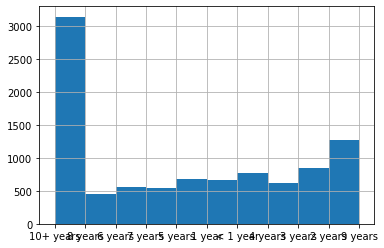

In [47]:
df['Years in current job'].hist()

In [48]:
df['Years in current job'].value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

In [49]:
df['years_in_cur_job'] = df['Years in current job']#.apply(lambda x: x.replace(' years',''))

In [50]:
df['years_in_cur_job'] = np.where(df['years_in_cur_job'].isnull(), -10, df['years_in_cur_job'])

In [51]:
def repl_years(x):
    if x == -10:
        return -10
    if x == '10+ years':
        return 10
    if x == '< 1 year':
        return 0
    if x == '1 year':
        return 1
    return x.replace(' years','')

In [52]:
df['years_in_cur_job'] = df['years_in_cur_job'].apply(lambda x: repl_years(x))

In [53]:
df['years_in_cur_job'] = df['years_in_cur_job'].astype(int)

In [54]:
df['years_in_cur_job'].value_counts()

 10    3142
 2      917
 3      848
 0      770
 5      685
 1      657
 4      621
 6      563
 7      536
-10     457
 8      446
 9      358
Name: years_in_cur_job, dtype: int64

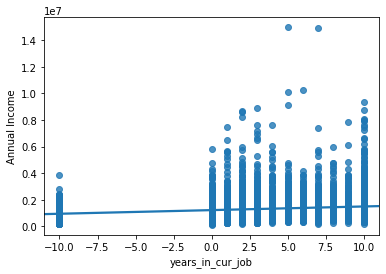

In [55]:
sns.regplot(
        x='years_in_cur_job',
        y='Annual Income',
        data=df,
        scatter=True,
        fit_reg=True
    )

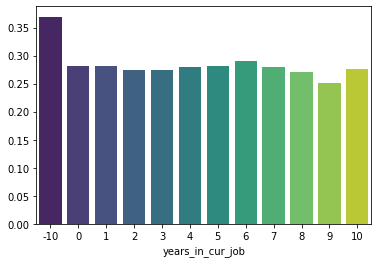

In [56]:
statistics = df.groupby(['years_in_cur_job'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [57]:
df['years_in_cur_job01'] = np.where(df['years_in_cur_job']==-10, 1, 0)

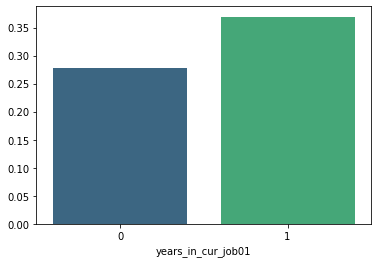

In [58]:
statistics = df.groupby(['years_in_cur_job01'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

Разное распределение целевой переменной только в зависимости от того years_in_cur_job запонено или нет. Зависимости от самого значений years_in_cur_job практически нет

In [59]:
df['Tax Liens'].value_counts()

0.0     9811
1.0      128
2.0       35
3.0       11
4.0        7
5.0        3
6.0        3
15.0       1
7.0        1
Name: Tax Liens, dtype: int64

In [60]:
df.loc[df['Tax Liens'].isnull()==True, 'Tax Liens'].count()

0

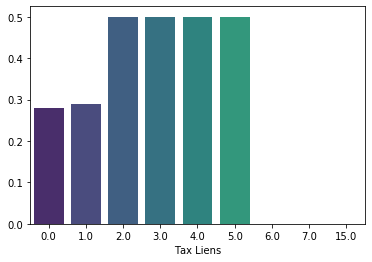

In [61]:
statistics = df.groupby(['Tax Liens'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [62]:
df['tax_liens'] = np.where(df['Tax Liens'] <= 1, 0, 1)

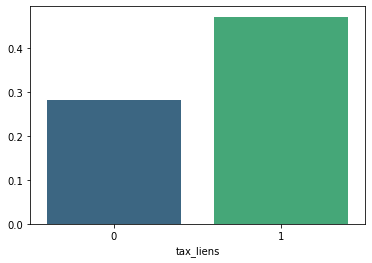

In [63]:
statistics = df.groupby(['tax_liens'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

Значения tax_liens >= 2 практически не влияют на целевую переменную, поэтому их выделять нет смысла

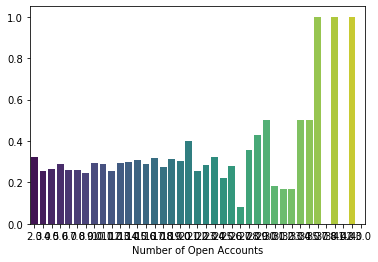

In [65]:
statistics = train_data.groupby(['Number of Open Accounts'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [66]:
train_data.groupby(['Number of Open Accounts'], as_index=False).agg({'Credit Default':['count', 'mean']})

Number of Open Accounts Credit Default          
                                    count      mean
0                      2.0             28  0.321429
1                      3.0             95  0.252632
2                      4.0            212  0.264151
3                      5.0            325  0.289231
4                      6.0            504  0.257937
5                      7.0            613  0.257749
6                      8.0            638  0.247649
7                      9.0            728  0.295330
8                     10.0            677  0.290990
9                     11.0            692  0.254335
10                    12.0            562  0.293594
11                    13.0            465  0.296774
12                    14.0            420  0.309524
13                    15.0            313  0.287540
14                    16.0            265  0.316981
15                    17.0            232  0.275862
16                    18.0            143  0.314685
17                    19.0            139  0.302158
18                    20.0             93  0.397849
19                    21.0             78  0.256410
20                    22.0             49  0.285714
21                    23.0             59  0.322034
22                    24.0             50  0.220000
23                    25.0             32  0.281250
24                    26.0             12  0.083333
25                    27.0             14  0.357143
26                    28.0             14  0.428571
27                    29.0             10  0.500000
28                    30.0             11  0.181818
29                    31.0              6  0.166667
30                    32.0              6  0.166667
31                    33.0              6  0.500000
32                    34.0              2  0.500000
33                    35.0              1  1.000000
34                    37.0              2  0.000000
35                    38.0              1  1.000000
36                    41.0              1  0.000000
37                    42.0              1  1.000000
38                    43.0              1  0.000000

In [67]:
def num_acc(x):
    if x == 2:
        return 0
    if x <= 8:
        return 1
    return 2

In [68]:
df['numb_open_acc'] = df['Number of Open Accounts'].apply(lambda x: num_acc(x))

Зависимости от количества открытых счетов практически не наблюдается. Оставим только три возможных значения

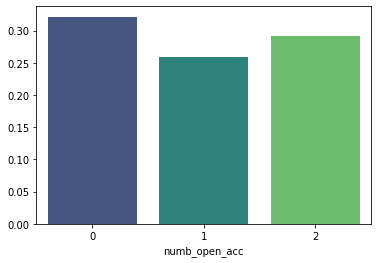

In [69]:
statistics = df.groupby(['numb_open_acc'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [70]:
df['Years of Credit History'].value_counts() 

16.0    131
15.0    126
16.5    126
17.0    116
14.0    115
       ... 
36.1      1
48.3      1
35.7      1
49.3      1
45.9      1
Name: Years of Credit History, Length: 423, dtype: int64

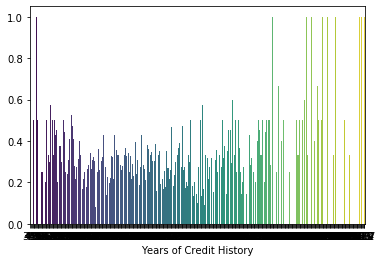

In [71]:
statistics = df.groupby(['Years of Credit History'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [72]:
df['Years of Credit History'].describe()

count    10000.000000
mean        18.319580
std          7.095357
min          3.900000
25%         13.500000
50%         17.000000
75%         22.000000
max         57.700000
Name: Years of Credit History, dtype: float64

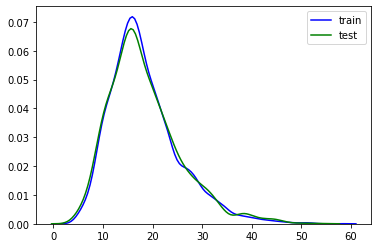

In [73]:
sns.kdeplot(train_data['Years of Credit History'], color="blue", label="train")
sns.kdeplot(test_data['Years of Credit History'], color="green", label="test")

Распределения Years of Credit History на трейне и тесте довольно похожи, что хорошо для модели

In [74]:
df['years_credit_history'] = df['Years of Credit History']

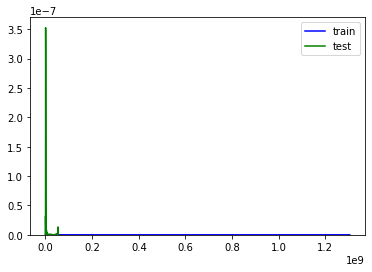

In [75]:
sns.kdeplot(train_data['Maximum Open Credit'], color="blue", label="train")
sns.kdeplot(test_data['Maximum Open Credit'], color="green", label="test")

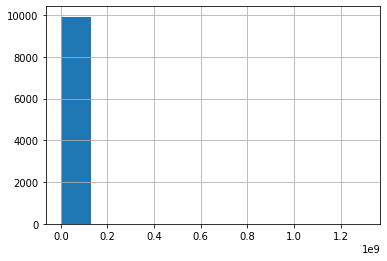

In [76]:
df.loc[df['Maximum Open Credit'] > 0, 'Maximum Open Credit'].hist()

In [77]:
df['Maximum Open Credit'].value_counts()

0.0         79
319110.0     5
294030.0     4
382954.0     4
334796.0     4
            ..
360118.0     1
430980.0     1
472736.0     1
225060.0     1
413644.0     1
Name: Maximum Open Credit, Length: 9096, dtype: int64

In [78]:
df.loc[df['Maximum Open Credit'] > 0, 'Maximum Open Credit'].describe()

count    9.921000e+03
mean     8.935671e+05
std      1.395483e+07
min      4.334000e+03
25%      2.832280e+05
50%      4.839120e+05
75%      7.978740e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [79]:
df['Maximum Open Credit'].quantile(.01)

17973.559999999998

In [80]:
df['max_open_credit'] = df['Maximum Open Credit']

In [81]:
df.loc[df['max_open_credit'] > df['max_open_credit'].quantile(.95), 'max_open_credit'].describe()

count    5.000000e+02
mean     7.486971e+06
std      6.183119e+07
min      1.713074e+06
25%      1.909699e+06
50%      2.261677e+06
75%      3.191430e+06
max      1.304726e+09
Name: max_open_credit, dtype: float64

In [82]:
df.loc[df['max_open_credit'] > df['max_open_credit'].quantile(.98), 'max_open_credit'] = \
  df['max_open_credit'].median()

In [83]:
df.loc[df['max_open_credit'] < df['max_open_credit'].quantile(.02), 'max_open_credit'] = \
  df['max_open_credit'].median()

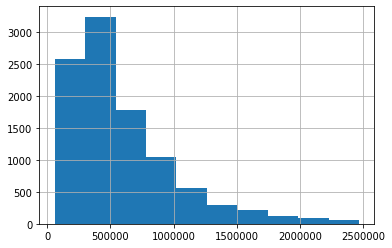

In [84]:
df.max_open_credit.hist()

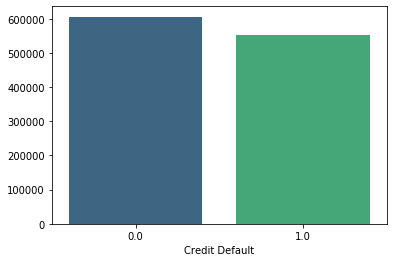

In [85]:
statistics = df.groupby(['Credit Default'])['max_open_credit'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [86]:
df['Number of Credit Problems'].value_counts() 

0.0     8646
1.0     1162
2.0      122
3.0       42
5.0       11
4.0       10
6.0        4
7.0        2
15.0       1
Name: Number of Credit Problems, dtype: int64

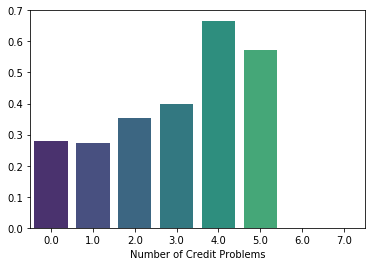

In [87]:
statistics = train_data.groupby(['Number of Credit Problems'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [88]:
def num_credit_problem(x):
    if x <= 1:
        return 0
    if x >= 5:
        return 5
    return x

In [89]:
df['numb_credit_problems'] = df['Number of Credit Problems'].apply(lambda x: num_credit_problem(x))

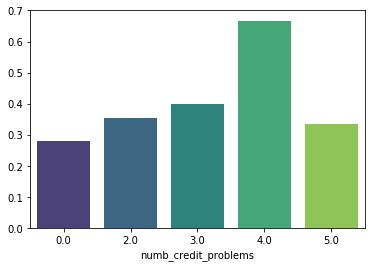

In [90]:
statistics = df.groupby(['numb_credit_problems'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [91]:
df['Monthly Debt'].value_counts()  

0.0        6
19667.0    4
12251.0    4
13162.0    4
19222.0    4
          ..
18349.0    1
24710.0    1
9811.0     1
2931.0     1
17.0       1
Name: Monthly Debt, Length: 8677, dtype: int64

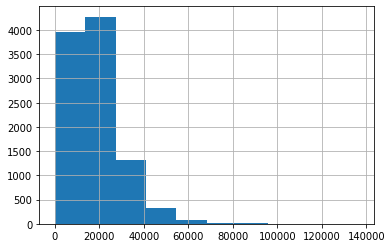

In [92]:
df['Monthly Debt'].hist()  

In [93]:
df['Monthly Debt'].describe()  

count     10000.000000
mean      18303.675600
std       11831.647516
min           0.000000
25%       10059.750000
50%       16200.000000
75%       23888.250000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [94]:
df['monthly_debt'] = df['Monthly Debt']

In [95]:
df['monthly_debt'].quantile(.99)

57593.05

In [96]:
df.loc[df['monthly_debt'] > df['monthly_debt'].quantile(.99), 'monthly_debt'] = \
  df['monthly_debt'].median()

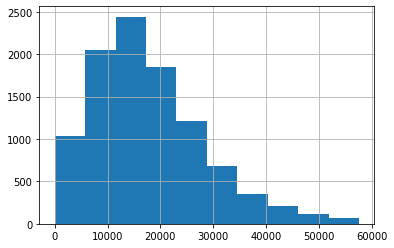

In [97]:
df['monthly_debt'].hist()  

In [98]:
df['monthly_debt_sign'] = np.sign(df['monthly_debt'])

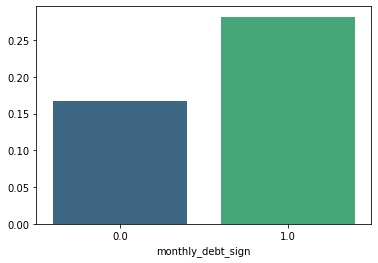

In [99]:
statistics = df.groupby(['monthly_debt_sign'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

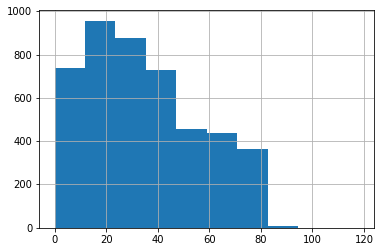

In [100]:
df['Months since last delinquent'].hist()  

In [101]:
df['Months since last delinquent'].describe()  

count    4561.000000
mean       34.564569
std        21.771990
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [102]:
df['months_since_last_delinquent'] = df['Months since last delinquent']

In [103]:
df['months_since_last_delinquent']=np.where(df['Months since last delinquent'].isnull(), -100, df['Months since last delinquent'])

In [104]:
df['months_since_last_delinquent'].describe()  

count    10000.000000
mean       -38.625100
std         68.619475
min       -100.000000
25%       -100.000000
50%       -100.000000
75%         29.000000
max        118.000000
Name: months_since_last_delinquent, dtype: float64

In [105]:
df.loc[df['months_since_last_delinquent'] > 81, 'months_since_last_delinquent'].value_counts()

82.0     7
83.0     3
92.0     1
91.0     1
84.0     1
118.0    1
86.0     1
Name: months_since_last_delinquent, dtype: int64

In [106]:
df['months_since_last_delinquent'] = df['months_since_last_delinquent'].apply(lambda x: min(x, 81))

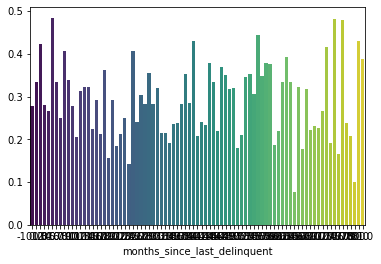

In [107]:
statistics = df.groupby(['months_since_last_delinquent'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [108]:
df['months_since_last_delinquent5'] = df['months_since_last_delinquent'].apply(lambda x: round(x/5))

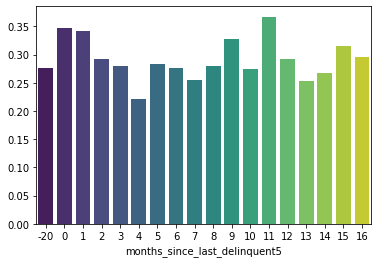

In [109]:
statistics = df.groupby(['months_since_last_delinquent5'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [110]:
df['months_since_last_delinquent10'] = df['months_since_last_delinquent'].apply(lambda x: round(x/10))

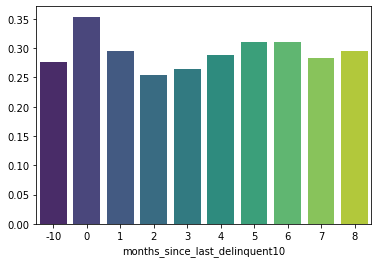

In [111]:
statistics = df.groupby(['months_since_last_delinquent10'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [112]:
df['months_since_last_delinquent_sign'] = df['months_since_last_delinquent'].apply(lambda x: np.sign(x))

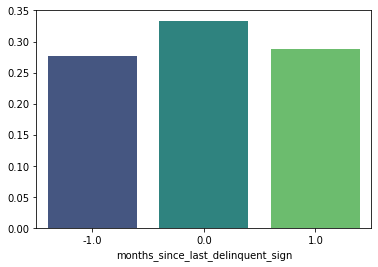

In [113]:
statistics = df.groupby(['months_since_last_delinquent_sign'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [114]:
df['Bankruptcies'].value_counts()

0.0    8912
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

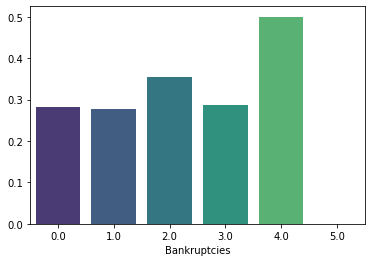

In [115]:
statistics = df.groupby(['Bankruptcies'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [116]:
df['bankrupt_']=df['Bankruptcies'].apply(lambda x: 0 if x <= 1 else 1)

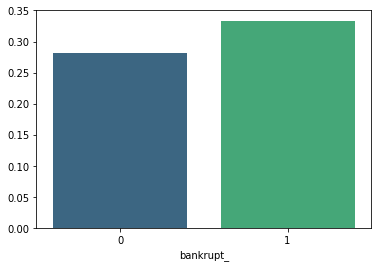

In [117]:
statistics = df.groupby(['bankrupt_'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [118]:
df.bankrupt_.value_counts()

0    9932
1      68
Name: bankrupt_, dtype: int64

In [119]:
df['Purpose'].value_counts()

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64

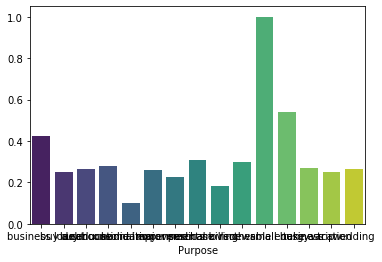

In [120]:
statistics = df.groupby(['Purpose'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [121]:
statistics.sort_values(ascending = False)

Purpose
renewable energy        1.000000
small business          0.538462
business loan           0.426357
medical bills           0.309859
other                   0.296241
debt consolidation      0.278264
take a trip             0.270270
wedding                 0.266667
buy house               0.264706
home improvements       0.262136
vacation                0.250000
buy a car               0.250000
major purchase          0.225000
moving                  0.181818
educational expenses    0.100000
Name: Credit Default, dtype: float64

In [122]:
statistics = df.groupby(['Purpose'], as_index=False).agg({'Credit Default':['count', 'mean']})

In [123]:
statistics.columns = ['Purpose', 'purpose_count', 'purpose_mean']

In [124]:
statistics.sort_values('purpose_mean', ascending = False)

,Purpose,purpose_count,purpose_mean
10,renewable energy,2,1.000000
11,small business,26,0.538462
0,business loan,129,0.426357
7,medical bills,71,0.309859
9,other,665,0.296241
3,debt consolidation,5944,0.278264
12,take a trip,37,0.270270
14,wedding,15,0.266667
2,buy house,34,0.264706
5,home improvements,412,0.262136


In [125]:
df = df.merge(statistics[['Purpose', 'purpose_mean']], on='Purpose', how='left')

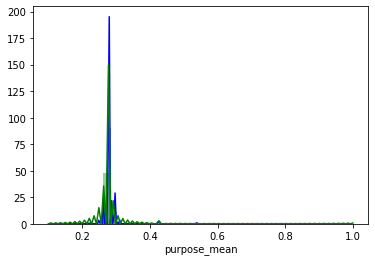

In [126]:
sns.distplot(df.loc[df['is_train']==1, 'purpose_mean'], color="blue", label="train")
sns.distplot(df.loc[df['is_train']==0, 'purpose_mean'], color="green", label="test")

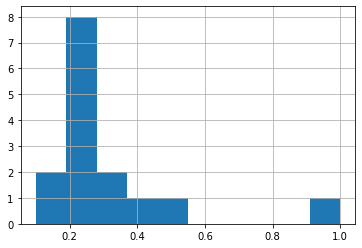

In [127]:
statistics.purpose_mean.hist()

In [128]:
def purpose_mean(x):
    if x >= 0.4:
        return 0.4
    if x >= 0.28:
        return 0.28
    if x >= 0.271:
        return 0.27
    if x >= 0.26:
        return 0.26
    if x >= 0.23:
        return 0.23
    return 0.2

In [129]:
df['purpose_mean_restr'] = df['purpose_mean'].apply(lambda x: purpose_mean(x))

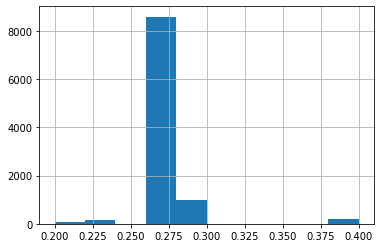

In [130]:
df.purpose_mean_restr.hist()

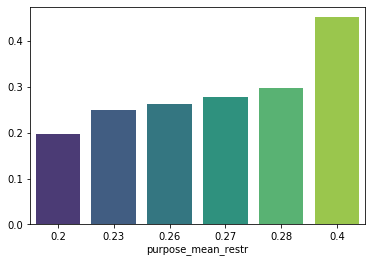

In [131]:
statistics = df.groupby(['purpose_mean_restr'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [132]:
df['Term'].value_counts()

Short Term    7417
Long Term     2583
Name: Term, dtype: int64

In [133]:
df['term_'] = df['Term'].map({'Short Term': 0, 'Long Term': 1})

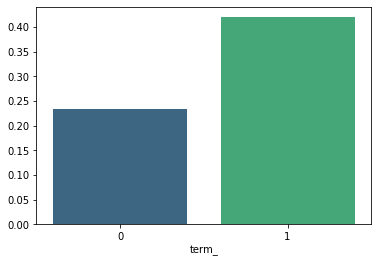

In [134]:
statistics = df.groupby(['term_'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [135]:
df['Current Loan Amount'].describe()

count    1.000000e+04
mean     1.194381e+07
std      3.200878e+07
min      1.124200e+04
25%      1.805485e+05
50%      3.117180e+05
75%      5.210700e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

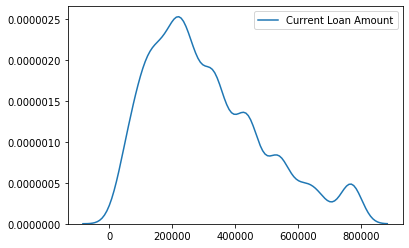

In [136]:
sns.kdeplot(df.loc[df['Current Loan Amount']<df['Current Loan Amount'].quantile(.99), 'Current Loan Amount'])

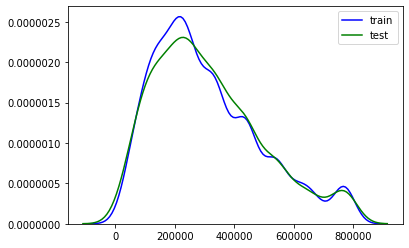

In [137]:
sns.kdeplot(train_data.loc[train_data['Current Loan Amount']<df['Current Loan Amount'].quantile(.99), 'Current Loan Amount'], color="blue", label="train")
sns.kdeplot(test_data.loc[test_data['Current Loan Amount']<df['Current Loan Amount'].quantile(.99), 'Current Loan Amount'], color="green", label="test")

In [138]:
loan_max = df['Current Loan Amount'].max()

In [139]:
df.loc[df['Current Loan Amount']<loan_max, 'Current Loan Amount'].max()

789096.0

In [140]:
df['current_loan_amount'] = df['Current Loan Amount'].apply(lambda x: min(x, 800000))

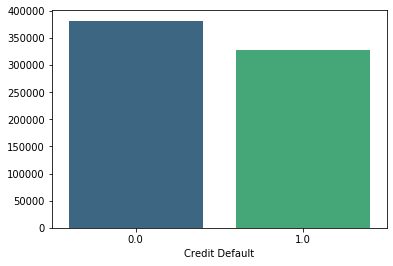

In [141]:
statistics = df.groupby(['Credit Default'])['current_loan_amount'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [142]:
df['current_loan_amount100'] = df.current_loan_amount.apply(lambda x: round(x/100000))

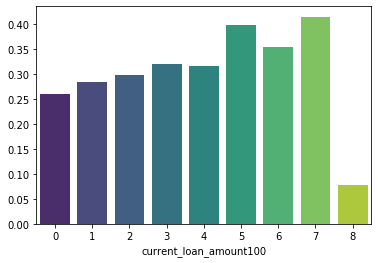

In [143]:
statistics = df.groupby(['current_loan_amount100'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [144]:
df['current_loan_amount25'] = df.current_loan_amount.apply(lambda x: round(x/25000))

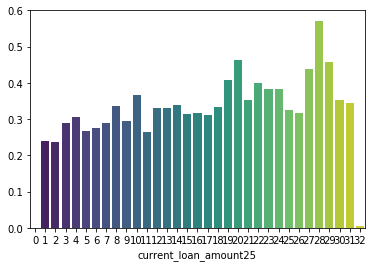

In [145]:
statistics = df.groupby(['current_loan_amount25'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [146]:
df['Current Credit Balance'].describe()

count    1.000000e+04
mean     2.914741e+05
std      3.339979e+05
min      0.000000e+00
25%      1.132258e+05
50%      2.090190e+05
75%      3.619500e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

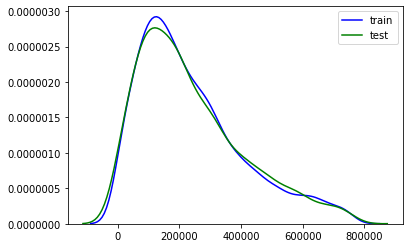

In [147]:
sns.kdeplot(train_data.loc[train_data['Current Credit Balance']<df['Current Credit Balance'].quantile(.95), 'Current Credit Balance'], color="blue", label="train")
sns.kdeplot(test_data.loc[test_data['Current Credit Balance']<df['Current Credit Balance'].quantile(.95), 'Current Credit Balance'], color="green", label="test")

In [148]:
df.loc[df['Current Credit Balance']>=df['Current Credit Balance'].quantile(.95), 'Current Credit Balance'].describe()

count    5.000000e+02
mean     1.296986e+06
std      7.833429e+05
min      7.625650e+05
25%      8.512618e+05
50%      1.003742e+06
75%      1.394586e+06
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

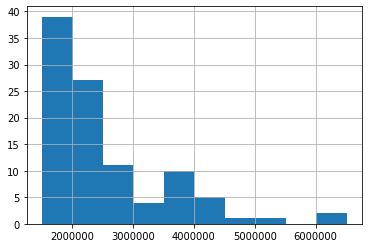

In [149]:
df.loc[df['Current Credit Balance']>=df['Current Credit Balance'].quantile(.99), 'Current Credit Balance'].hist()

In [150]:
df['current_credit_balance'] = df['Current Credit Balance'].apply(lambda x: min(x, 800000))

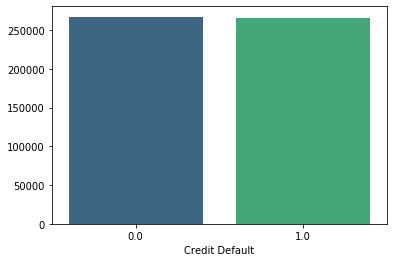

In [151]:
statistics = df.groupby(['Credit Default'])['current_credit_balance'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [152]:
df['current_credit_balance100'] = df.current_loan_amount.apply(lambda x: round(x/100000))

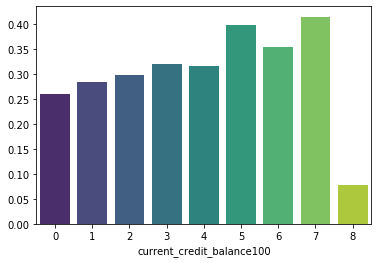

In [153]:
statistics = df.groupby(['current_credit_balance100'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

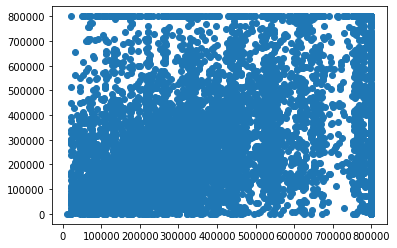

In [154]:
plt.scatter(df.current_loan_amount, df.current_credit_balance)

In [155]:
df['loan_ver_incom'] = df.current_loan_amount/df.annual_incom_redict

In [156]:
df.loan_ver_incom.max()

7.509410229694085

In [157]:
df.groupby(np.sign(df['Current Loan Amount']-df['Current Credit Balance'])).count()

,Annual Income,Bankruptcies,Credit Default,Credit Score,Current Credit Balance,Current Loan Amount,Home Ownership,Maximum Open Credit,Monthly Debt,Months since last delinquent,...,bankrupt_,purpose_mean,purpose_mean_restr,term_,current_loan_amount,current_loan_amount100,current_loan_amount25,current_credit_balance,current_credit_balance100,loan_ver_incom
-1.0,2311,3043,2304,2311,3049,3049,3049,3049,3049,1167,...,3049,3049,3049,3049,3049,3049,3049,3049,3049,3049
1.0,5619,6940,5196,5619,6951,6951,6951,6951,6951,3394,...,6951,6951,6951,6951,6951,6951,6951,6951,6951,6951


In [158]:
df['loan_ver_credit'] = round((df['Current Loan Amount']/df['Current Credit Balance'])*10)

In [159]:
df['loan_ver_credit'] = df.loan_ver_credit.apply(lambda x: min(x, 40))

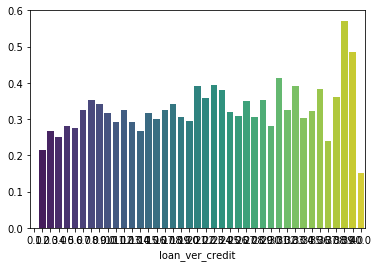

In [160]:
statistics = df.groupby('loan_ver_credit')['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

In [189]:
df2 = df.groupby('loan_ver_credit').agg({'Credit Default':'mean'})
df2.rename(columns={'Credit Default': 'loan_ver_credit_mean'} , inplace=True)
df2.head()

,loan_ver_credit_mean
loan_ver_credit,
0.0,0.000000
1.0,0.215054
2.0,0.268116
3.0,0.250000
4.0,0.279793


In [162]:
df = df.merge(df2, on='loan_ver_credit', how='left')

In [163]:
df.head()

,Annual Income,Bankruptcies,Credit Default,Credit Score,Current Credit Balance,Current Loan Amount,Home Ownership,Maximum Open Credit,Monthly Debt,Months since last delinquent,...,purpose_mean_restr,term_,current_loan_amount,current_loan_amount100,current_loan_amount25,current_credit_balance,current_credit_balance100,loan_ver_incom,loan_ver_credit,loan_ver_credit_mean
0,482087.0,1.0,0.0,749.0,47386.0,99999999.0,Own Home,685960.0,7914.0,NaN,...,0.27,0,800000.0,8,32,47386.0,8,1.659452,40.0,0.150882
1,1025487.0,0.0,1.0,737.0,394972.0,264968.0,Own Home,1181730.0,18373.0,NaN,...,0.27,1,264968.0,3,11,394972.0,3,0.258383,7.0,0.351852
2,751412.0,0.0,0.0,742.0,308389.0,99999999.0,Home Mortgage,1182434.0,13651.0,NaN,...,0.27,0,800000.0,8,32,308389.0,8,1.064662,40.0,0.150882
3,805068.0,1.0,0.0,694.0,95855.0,121396.0,Own Home,147400.0,11338.0,NaN,...,0.27,0,121396.0,1,5,95855.0,1,0.150790,13.0,0.267797
4,776264.0,0.0,0.0,719.0,93309.0,125840.0,Rent,385836.0,7180.0,NaN,...,0.27,0,125840.0,1,5,93309.0,1,0.162110,13.0,0.267797


In [164]:
df['last_len'] = round((df.current_loan_amount/np.where(df.monthly_debt <=0, -1, df.monthly_debt)/12))

In [165]:
df['last_len'] = df.last_len.apply(lambda x: min(x, 5))

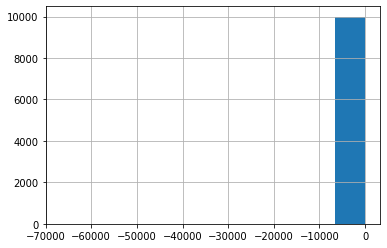

In [166]:
df.last_len.hist()

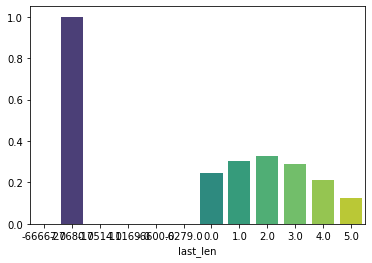

In [167]:
statistics = df.groupby(['last_len'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

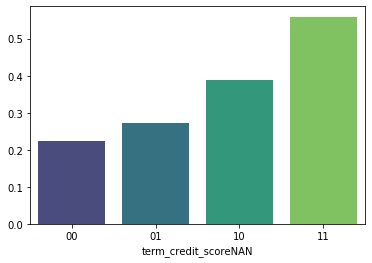

In [168]:
df['term_credit_scoreNAN'] = df.agg('{0[term_]}{0[credit_scoreNAN]}'.format, axis=1)

statistics = df.groupby(['term_credit_scoreNAN'])['Credit Default'].mean()

sns.barplot(
    x=statistics.index,
    y=statistics.values,
    palette="viridis"
)

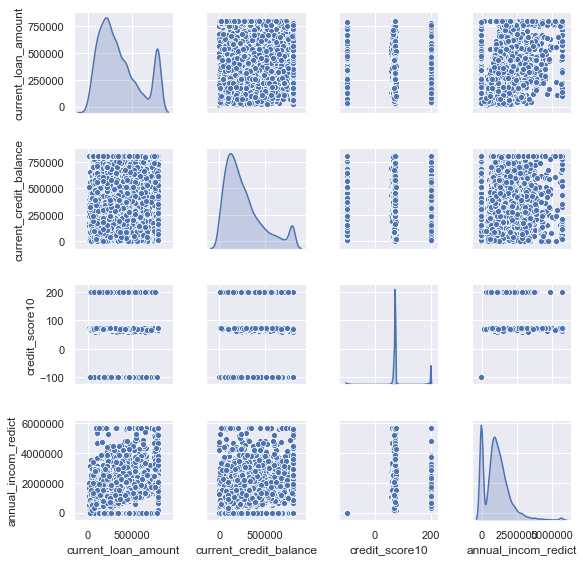

In [188]:
sns.set()
columns = [
 'current_loan_amount',
 'current_credit_balance',
 'credit_score10',
 'annual_incom_redict',
]

sns.pairplot(df[columns], size=2, kind="scatter", diag_kind="kde")
plt.show()

Корреляции между данными признаками не видно

#### Используемые функции

In [170]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [171]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.2, 0.7, 50):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3).head(20)
  
    figure = plt.figure(figsize = (30, 10))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

#### Построение модели

In [172]:
feature_names = [
 'credit_score10',
 'current_loan_amount',
 'term_credit_scoreNAN',
 'loan_ver_incom',
 'annual_incom_redict',
 'max_open_credit',
 'monthly_debt',
 'years_credit_history',
 'current_credit_balance',
 'years_in_cur_job',
 'last_len',
 'years_in_cur_job01'
]

target_name = 'Credit Default'

In [173]:
X = df.loc[np.isnan(df['Credit Default'])==False, feature_names]
y = df.loc[np.isnan(df['Credit Default'])==False, target_name]

In [174]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [175]:
RFC_model = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42, max_features=7)

In [176]:
RFC_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [177]:
y_train_pred_proba = RFC_model.predict_proba(X_train)
y_valid_pred_proba = RFC_model.predict_proba(X_valid)

In [178]:
threshold = 0.292
get_classification_report(y_train, np.where(pd.DataFrame(y_train_pred_proba)[1] > threshold, 1, 0), y_valid, np.where(pd.DataFrame(y_valid_pred_proba)[1] > threshold, 1, 0))

TRAIN

              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      3795
         1.0       0.58      0.60      0.59      1455

    accuracy                           0.77      5250
   macro avg       0.71      0.71      0.71      5250
weighted avg       0.77      0.77      0.77      5250

TEST

              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      1592
         1.0       0.55      0.55      0.55       658

    accuracy                           0.73      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.73      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0.0             1290  302
1.0              295  363


In [179]:
feature_importances = pd.DataFrame(zip(feature_names, RFC_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).feature_name.tolist()

['credit_score10',
 'current_loan_amount',
 'term_credit_scoreNAN',
 'loan_ver_incom',
 'annual_incom_redict',
 'max_open_credit',
 'monthly_debt',
 'years_credit_history',
 'current_credit_balance',
 'years_in_cur_job',
 'last_len',
 'years_in_cur_job01']

In [180]:
y_train_pred_prob = RFC_model.predict_proba(X_train)
y_valid_pred_prob = RFC_model.predict_proba(X_valid)

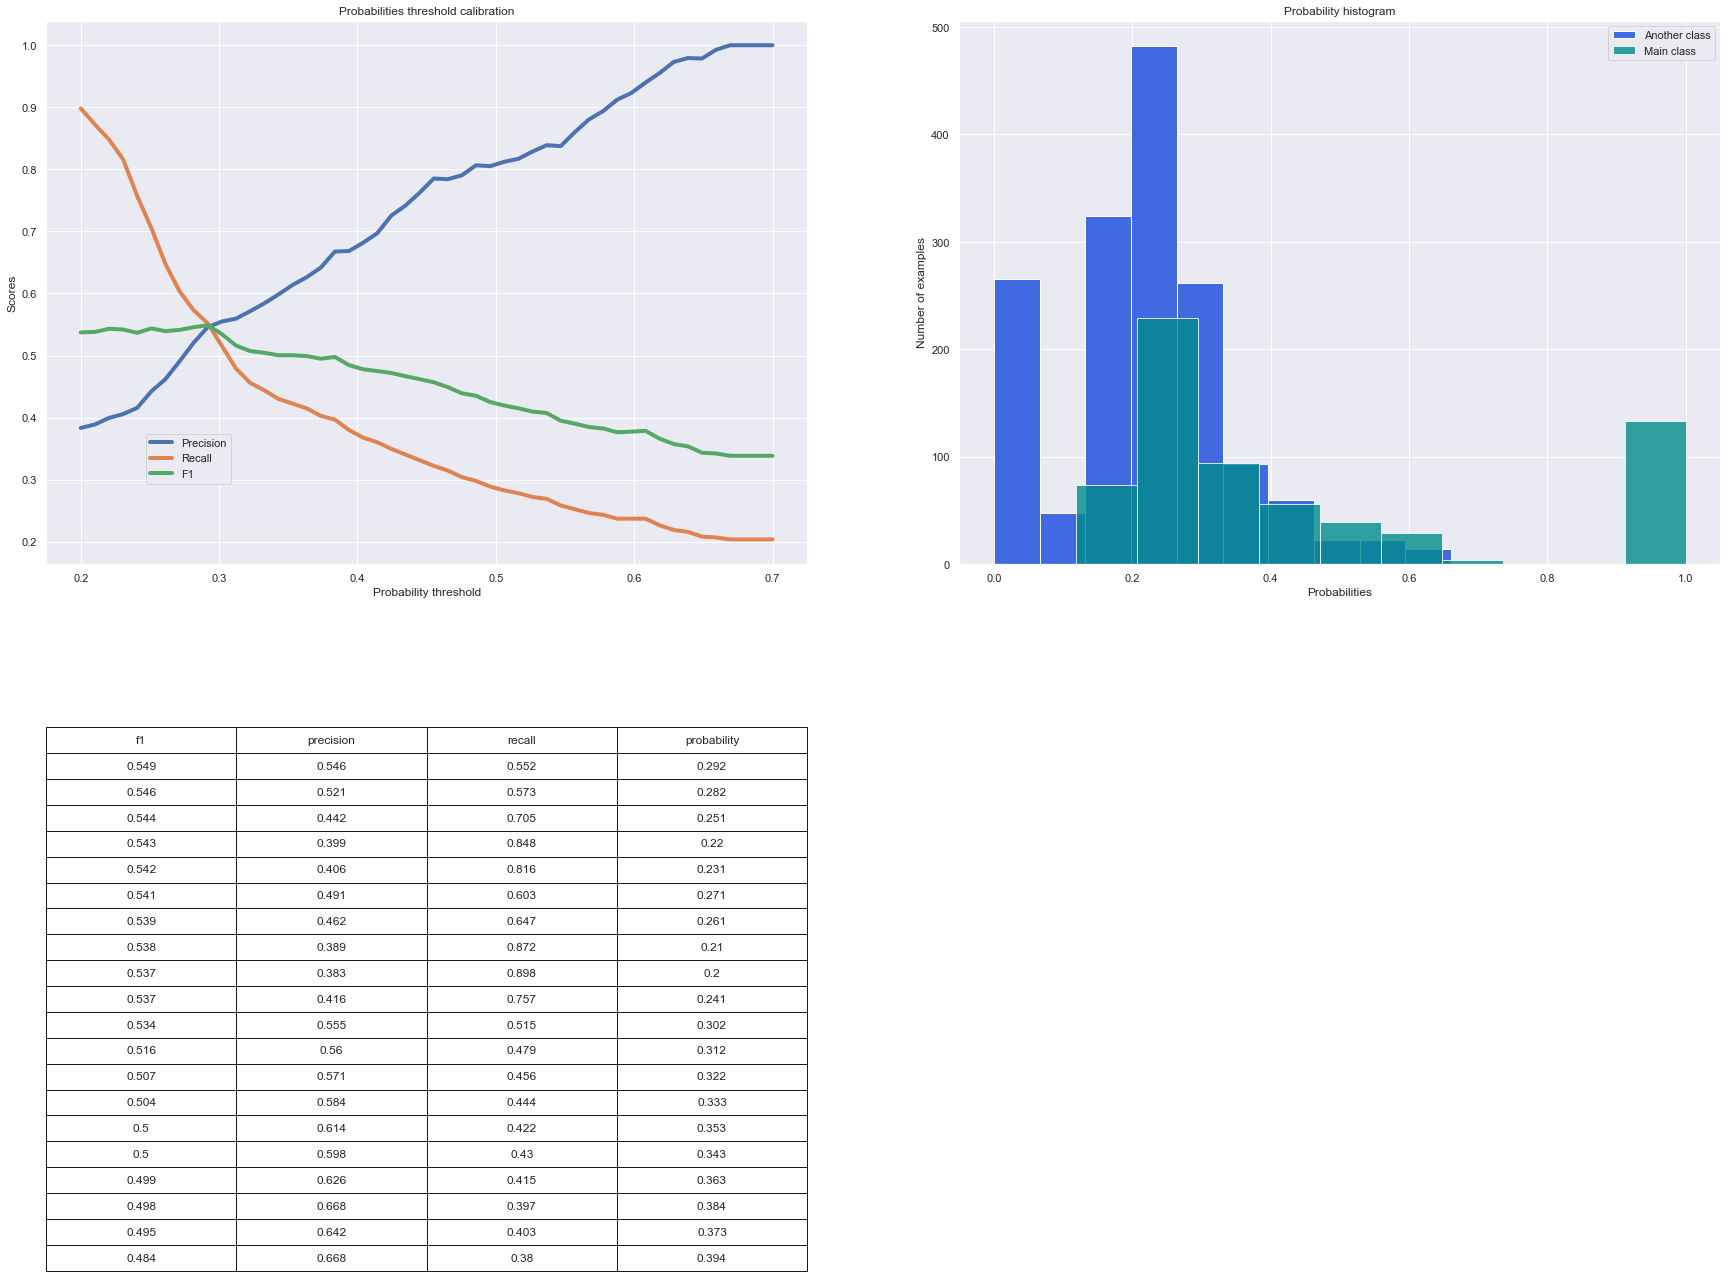

In [182]:
show_proba_calibration_plots(y_valid_pred_prob[:, 1], y_valid)

#### Выгрузка результатов

In [183]:
X_test = df.loc[np.isnan(df['Credit Default']), feature_names]

X_test['Credit Default'] = RFC_model.predict(X_test[feature_names].values)

y_test = X_test.loc[:, 'Credit Default']

y_test.head()

7500    0.0
7501    0.0
7502    1.0
7503    0.0
7504    0.0
Name: Credit Default, dtype: float64

In [184]:
y_test.to_csv('Zharova_Natalija_predictions.csv', index=False)